In [1]:
pip install torchinfo

In [2]:
import diffusers
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import display
from PIL import Image
from torchinfo import summary
from tqdm.notebook import tqdm

In [3]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(device, dtype)

cuda torch.float16


In [4]:
tokenizer = transformers.CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="tokenizer",
    torch_dtype=dtype
)

print(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


Stable Diffusion creates images based on text prompts, but first, it must translate those prompts into a numerical format the model can understand. This process is called embedding.

I'll use CLIP for this. CLIP helps connect language and images by turning text into embeddings—basically, a set of numbers capturing the meaning of the input.

One crucial step in this is tokenisation, which breaks the input text into smaller parts like words, word fragments, or even characters. Stable Diffusion doesn't need the whole CLIP model, only the tokenizer part, which we load using the subfolder argument.

In [5]:
sample = "Hello Anthony, How are you doing today?"
result = tokenizer(sample)

print(result.input_ids)

[49406, 3306, 6113, 267, 829, 631, 592, 1960, 721, 286, 49407]


The input_ids hold the token ID numbers that my input text was split into. Each of these numbers stands for a token which are parts of my original string, including punctuations. To see what each token ID translates back to, I can use `tokenizer.decode`.

In [6]:
for token in result.input_ids:
    print(tokenizer.decode(token))

<|startoftext|>
hello
anthony
,
how
are
you
doing
today
?
<|endoftext|>


Now onto my first image from the stable diffusion. I'll tokenize it and have it return a pytorch tensor instead of a python list.

In [7]:
prompt = 'A red sedan driving through the countryside'

token = tokenizer(prompt, return_tensors='pt', padding='max_length', truncation=True)

token.input_ids

tensor([[49406,   320,   736, 24237,  4161,  1417,   518, 16303, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [8]:
token.input_ids.shape

torch.Size([1, 77])

Now the above was for a conditioned model. Now to see what a unconditioned would look like:

In [9]:
uncon_token = tokenizer("", return_tensors='pt', padding='max_length', truncation=True)
print('IDs: ',token.input_ids)
print()
print('IDs shape: ',token.input_ids.shape)

IDs:  tensor([[49406,   320,   736, 24237,  4161,  1417,   518, 16303, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

IDs shape:  torch.Size([1, 77])


These tokens, however, are just numerical IDs that represent pieces of my text prompt. They don't carry much meaning on their own. The `text_encoder` takes these token IDs and transforms them into a dense vector representation - a text embedding - that captures the actual semantic meaning of my text.

In [10]:
embedder = transformers.CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
    torch_dtype=dtype
)
embedder.to(device)

summary(embedder)

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Param #
CLIPTextModel                                                --
├─CLIPTextTransformer: 1-1                                   --
│    └─CLIPTextEmbeddings: 2-1                               --
│    │    └─Embedding: 3-1                                   37,945,344
│    │    └─Embedding: 3-2                                   59,136
│    └─CLIPEncoder: 2-2                                      --
│    │    └─ModuleList: 3-3                                  85,054,464
│    └─LayerNorm: 2-3                                        1,536
Total params: 123,060,480
Trainable params: 123,060,480
Non-trainable params: 0

In [11]:
with torch.no_grad():
    embedding = embedder(token.input_ids.to(device))

In [12]:
print(embedding.keys())

odict_keys(['last_hidden_state', 'pooler_output'])


The embedding of interest is found in the `last_hidden_state` attribute, where the `text_encoder` stores the final, meaningful vector representations of my input text. These embeddings guide the image generation process in Stable Diffusion.

In [13]:
print(embedding.last_hidden_state)
print()
print(f'Embedding size: {embedding.last_hidden_state.shape}')

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0297, -1.3242,  0.3076,  ..., -0.5234,  0.9746,  0.6650],
         [ 0.7241, -1.4619, -0.4299,  ..., -0.7935, -1.1162,  1.0361],
         ...,
         [-0.0197,  0.0536, -0.5283,  ...,  0.3704,  0.1609, -0.2554],
         [-0.0413,  0.0286, -0.5522,  ...,  0.3833,  0.1390, -0.2725],
         [-0.0233,  0.1244, -0.3430,  ...,  0.3396,  0.2998, -0.2966]]],
       device='cuda:0', dtype=torch.float16)

Embedding size: torch.Size([1, 77, 768])


In [14]:
# Now for unconditioned:
with torch.no_grad():
    uncon_embedding = embedder(uncon_token.input_ids.to(device))

Up next is to concatenate the unconditioned embedding with the text embedding to form a single tensor as Stable Diffusion needs both to do its job propelky. By including both embeddings—one with context (text) and one without (unconditioned)—the model can strike a balance between creativity and alignment to my input prompt. torch.cat lets me stack them efficiently in the right order for the model to use during denoising.

In [15]:
all_embeddings = torch.cat([uncon_embedding.last_hidden_state, embedding.last_hidden_state])

print(all_embeddings.shape)

torch.Size([2, 77, 768])


# Generate Random Latent Vectors

I’m once again loading the VAE model from its specific subfolder because Stable Diffusion is modular with each part sitting in its own compartment.

At this stage, I’m generating completely random latent vectors, and VAE is the go-to model for working with VAEs. These are just noise for now, but later on, they’ll be gradually refined to represent meaningful image content. The VAE will eventually decode these refined latent vectors into actual pixel-level images.

In [16]:
vae = diffusers.AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae",
    torch_dtype=dtype
)
vae.to(device)

summary(vae)

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Param #
AutoencoderKL                                      --
├─Encoder: 1-1                                     --
│    └─Conv2d: 2-1                                 3,584
│    └─ModuleList: 2-2                             --
│    │    └─DownEncoderBlock2D: 3-1                738,944
│    │    └─DownEncoderBlock2D: 3-2                2,690,304
│    │    └─DownEncoderBlock2D: 3-3                10,754,560
│    │    └─DownEncoderBlock2D: 3-4                9,443,328
│    └─UNetMidBlock2D: 2-3                         --
│    │    └─ModuleList: 3-5                        1,051,648
│    │    └─ModuleList: 3-6                        9,443,328
│    └─GroupNorm: 2-4                              1,024
│    └─SiLU: 2-5                                   --
│    └─Conv2d: 2-6                                 36,872
├─Decoder: 1-2                                     --
│    └─Conv2d: 2-7                                 18,944
│    └─ModuleList: 2-8

I'll aim to produce 512 x 512 images, and add a scale factor of 8 which the encoder will downscale by and the decoder will upscale by, too.

In [17]:
height = 512
width = 512
sf = 8

In [18]:
# For the number of channels in the latent vector:
n_channels = vae.config.latent_channels
print(n_channels)

4


Latent vectors will be a 4-D tensor, representing (batch, channel, height, width). The number of channels being 4 is a coincidence.

To generate a random latent vector, using `torch.randn`:

In [19]:
latent_shape = (1, n_channels, (height // sf), (width // sf))

rand_latents = torch.randn(latent_shape, device=device, dtype=dtype)

rand_latents.shape

torch.Size([1, 4, 64, 64])

Since the latent vectors have four channels, It can’t be visualised as a standard RGB image. Each the four channels can be plot separately, just to get a sense of what’s going on inside the latent space.


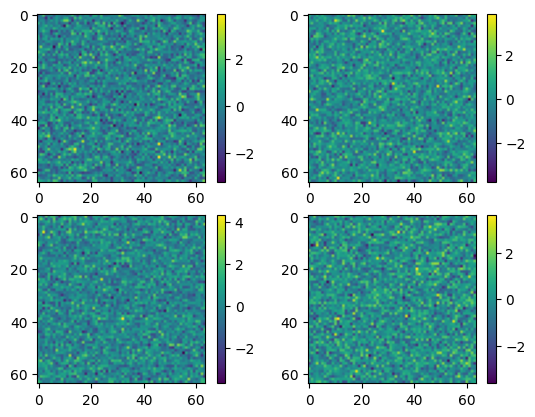

In [20]:
def plot_latents(latents):
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(latents[0, i].cpu().numpy())
        plt.colorbar()

plot_latents(rand_latents)

In [21]:
latents = rand_latents
# Decode the latents
with torch.no_grad():
    scaling_factor = torch.tensor(vae.config.scaling_factor, device=device, dtype=dtype)
    decoded = vae.decode(latents / scaling_factor).sample

The decoded will have its shape in (batch, channels, height, width) format. However, PIL expects images in (height, width, channels) format. We can use the .permute() method to switch things around. We'll also convert the tensor into a NumPy array.

In [22]:
decoded.shape

torch.Size([1, 3, 512, 512])

In [23]:
unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
unscaled.shape

(1, 512, 512, 3)

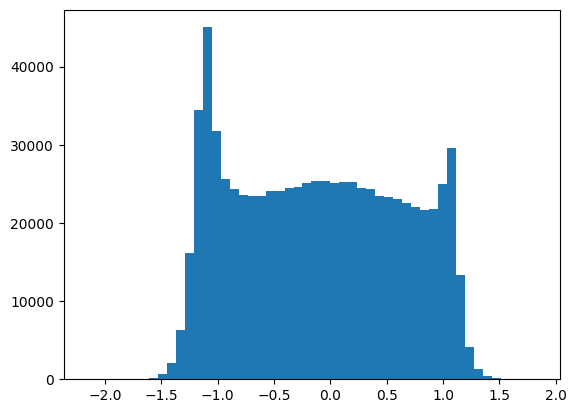

In [24]:
plt.hist(unscaled.flatten(),bins=50);

This reveals that most values fall within the range of [-1, 1]. To prepare the data for image display, i'll rescale it to [0, 255], and cast the array to the standard unsigned 8-bit integer type used for images.

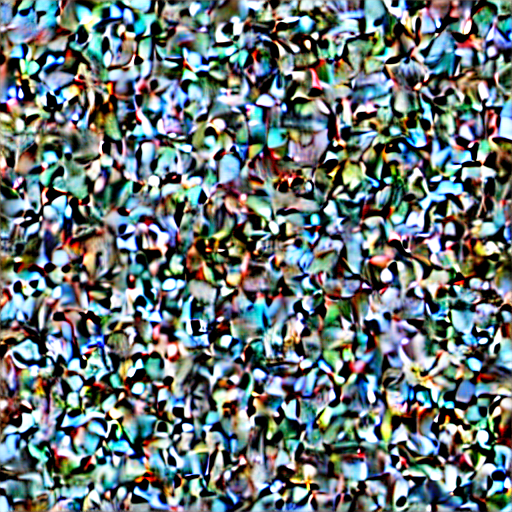

In [25]:
def latents_to_image(latents, vae=vae):
    scaling_factor = torch.tensor(vae.config.scaling_factor, device=device, dtype=dtype)
    with torch.no_grad():
        decoded = vae.decode(latents / scaling_factor).sample
    unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
    scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")
    return Image.fromarray(scaled[0])

latents_to_image(rand_latents)

# Denoising Diffusion

The above generated image was generate from random latents and look noting at all like the prompt/input, next is to denoise it. For this, i'll employ the U-Net model, a condition model, that will take the text embedding as input, to judge how well the denoised image matches the text.

In [26]:
unet = diffusers.UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16)
unet.to(device)
summary(unet)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Layer (type:depth-idx)                                            Param #
UNet2DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─ModuleList: 1-4                                                 --
│    └─CrossAttnDownBlock2D: 2-4                                  --
│    │    └─ModuleList: 3-1                                       5,092,480
│    │    └─ModuleList: 3-2                                       4,510,080
│    │    └─ModuleList: 3-3                                       921,920
│    └─CrossAttnDownBlock2D: 2-5                               

The U-Net model is trained to handle noise gradually, step by step. A scheduler controls this stepwise denoising process.

In [27]:
scheduler = diffusers.UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
print(scheduler)

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

UniPCMultistepScheduler {
  "_class_name": "UniPCMultistepScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "final_sigmas_type": "zero",
  "flow_shift": 1.0,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_flow_sigmas": false,
  "use_karras_sigmas": false
}



We start by scaling the latent vector, even though the factor is 1.0 here, just to stay consistent across schedulers. Then set up a single denoising step and duplicate the latent vector so both the unconditioned and conditioned inputs can run together. This makes the noise prediction more efficient.

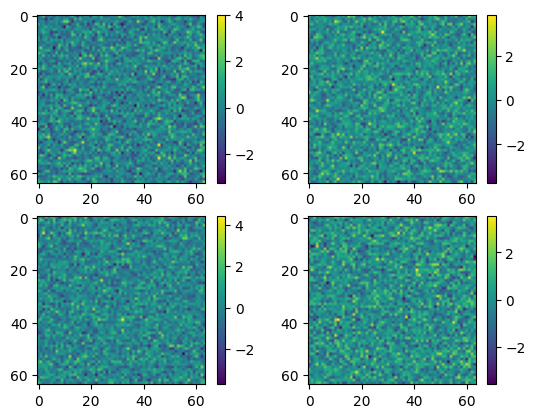

In [28]:
latents = rand_latents * scheduler.init_noise_sigma
scheduler.set_timesteps(1)
t = scheduler.timesteps[0]

latent_inputs = torch.cat([latents, latents])
scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)

# Ensure matching dtype/device
all_embeddings = all_embeddings.to(dtype=scaled_inputs.dtype, device=scaled_inputs.device)

with torch.no_grad():
    noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)

# Split predictions
noise_uncond, noise_cond = noise.sample.chunk(2)
guidance_scale = 7.5
noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

plot_latents(noise_pred)

The scheduler’s .step method can be used to subtract the predicted noise from the latent vector.

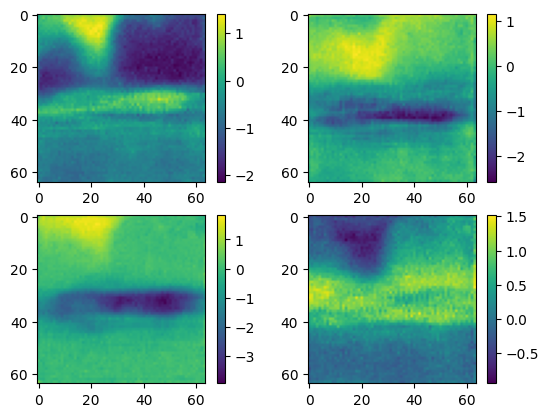

In [30]:
latents = scheduler.step(noise_pred, t, latents).prev_sample

plot_latents(latents)

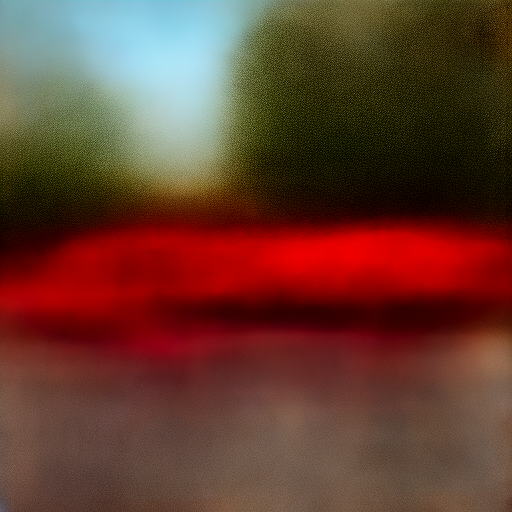

In [31]:
latents_to_image(latents)

The image is still forming, but the quality will improve as we increase the number of denoising steps. Next, we’ll loop through 60 steps to progressively refine the image, starting from noisy and gradually becoming clear near the end.

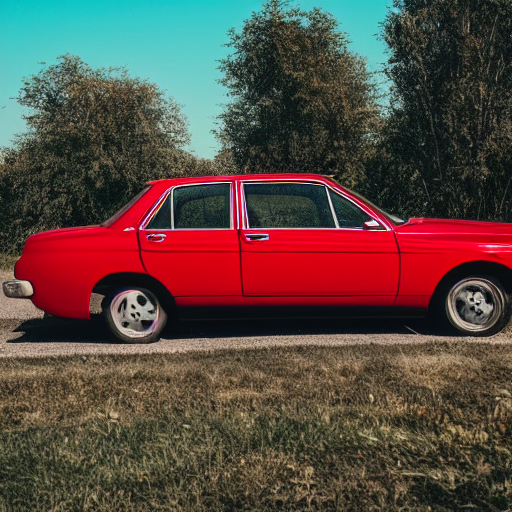

  0%|          | 0/60 [00:00<?, ?it/s]

In [33]:
num_steps = 60
scheduler.set_timesteps(num_steps)

latents = rand_latents * scheduler.init_noise_sigma

display_handle = display(latents_to_image(latents, vae), display_id="latent_display")

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        latent_inputs = torch.cat([latents, latents])
        scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)
        with torch.no_grad():
            noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)
        noise_uncond, noise_cond = noise.sample.chunk(2)
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        display_handle.update(latents_to_image(latents, vae))